In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  LassoCV,
                                  Lasso)
#  Lasso, RandomizedLasso are removed, need them later
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
import os
from sklearn.metrics import r2_score
from scipy.stats import nbinom
# check xgboost version

# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import the train_test_split method
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
colorvaris = {
    "R":"#BCBEC0",
    'P':'#ea1121',
    'S':'#3BC0CF',
    'poi_gsv':'#016699',
    "gsvalone":"#2F7864",
    "poi":'#ea1121',
    'gsv':'#3BC0CF',
    "core":"#BCBEC0"
             }
# plt.rcParams["figure.autolayout"] = True
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
targetNames = {
    
    # crime
    "logcrime":"Log(Violent Crime)",
    "logpetty":"Log(Petty Crime)",
          
          # nonvehicle travel
     "walkbike_per_cbg":"%Walk",
    "publictrans_per_cbg":"%Public Transit",
    "drove_alone_per_cbg":"% Drive Alone",
       
          # vehiclde travel
          'estvmiles':"VMT", 
    'estvtrp':"VTRP", 
    'estptrp':"PTRP",  
    'estpmiles':"PMT", 
          
          # health outcome
             "obesitycru":"% Obesity", 
             "bphighcrud":"% High Blood Pressure", 
             "diabetescr":"% Diabetes", 
             "lpacrudepr":"% LPA", 
          "mhlthcrude":"% Mental Health",
    'phlthcrude':"% Physical Health",
    'cancercrud':"% Cancer Health",
          
          # inequality
    "logincome":"Log(Income)",
    "povertyline_below200":"% Poverty Line (200%)",
    "povertyline_below100":"% Poverty Line (100%)",


}

In [60]:
target = [

    "logcrime",
    "logpetty",

          
          # nonvehicle travel
            "walkbike_per_ct",
            "publictrans_per_ct",
    "drove_alone_per_ct",
       
          # vehiclde travel
          'estvmiles', 
    'estvtrp', 
    'estptrp', 
    'estpmiles',
          
          # health outcome
             "obesitycru",

             "diabetescr",
             "lpacrudepr",
          "mhlthcrude",
    'phlthcrude', 

    'cancercrud', 
          
          # inequality

    "logincome",
    "povertyline_below200",
    "povertyline_below100"


            ]
topicdict = dict(zip(
    target,
    [


        'Crime',
        'Crime',
     'Non-vehicle Travel', 
        'Non-vehicle Travel',
        'Vehicle Travel',
     
     'Vehicle Travel','Vehicle Travel','Vehicle Travel','Vehicle Travel',
     
     'Health', 'Health',
        'Health','Health','Health',
        'Health',


        'Poverty', 
        'Poverty',
        'Poverty',

     ]
))


plotorderdict = {
    'Vehicle Travel':2,
    'Non-vehicle Travel':1,
    'Health':3,
    'Poverty':4,
    "Crime":5,
    "Population":6

}
colortopics = list(sns.color_palette("husl", 5))
colortopicset = dict(zip(plotorderdict.keys(),colortopics))

tempfolder = "../table/temp"
if not os.path.exists(tempfolder):
    os.makedirs(tempfolder)

In [8]:
graphicsave = "../graphic"
tablefolder = "../table/"
datafolder = "../data"

unit = "ct" # change here to conduct different analysis

file_name = os.path.join(datafolder, "allparameters_ct.csv")

# preprocessing
df = pd.read_csv(file_name)

In [9]:
datasum = df[target].describe().T.reset_index().rename(columns ={"index":"target"})
datasum["topic"] = datasum["target"].apply(lambda x: topicdict[x])
datasum

,target,count,mean,std,min,25%,50%,75%,max,topic
0,logcrime,4605.0,2.774176,1.112523,0.00000,2.079442,2.772589,3.496508,6.908755,Crime
1,logpetty,4605.0,2.960481,1.590277,0.00000,1.609438,3.295837,4.189655,7.907652,Crime
2,walkbike_per_ct,13104.0,5.194411,8.258506,0.00000,0.880000,2.470000,6.080000,100.000000,Non-vehicle Travel
3,publictrans_per_ct,13104.0,18.675361,20.670957,0.00000,3.350000,9.620000,28.002500,100.000000,Non-vehicle Travel
4,drove_alone_per_ct,13104.0,62.054429,23.094768,0.00000,48.897500,70.715000,79.590000,100.000000,Vehicle Travel
5,estvmiles,12608.0,32.111214,12.498457,4.66000,23.370000,32.460000,40.852500,73.700000,Vehicle Travel
6,estvtrp,12604.0,4.466951,1.343374,0.88000,3.660000,4.710000,5.440000,7.280000,Vehicle Travel
7,estptrp,12628.0,8.355790,1.137895,4.67000,7.610000,8.440000,9.172500,11.260000,Vehicle Travel
8,estpmiles,12614.0,50.393158,13.666885,21.43000,39.970000,49.675000,59.757500,98.970000,Vehicle Travel
9,obesitycru,11450.0,27.374096,6.262332,11.90000,22.800000,26.700000,31.300000,50.800000,Health


In [14]:
citylist = df["city"].unique()

In [10]:
# Set up variable groups

# global pois totalpoi retail accommodat finance transporta constructi manufactur health education arts parkarea stationdis
# global gsv sky plantingt plantingg facade streetfur window road paving person vehicleh vehiclel bike nature planting
# global demo distancece landareacb totpop over65perc bachelorcb mhincomecb popdensity poccbg19

gsv = [
     'facade', 'window', 'recreation', 'road',
       'paving', 'streetfurn', 'landmark', 'plantingt', 'plantingg', 
    'sky',
       'ground', 'nature', 
    'person', 'bike', 'vehicleh', 'vehiclel'
]

gsvnb = [f"{g}_nb" for g in gsv]

loggsvs = []
for p in gsv+gsvnb:
    df[p] = df[p].fillna(0)
    df[f"log{p}"] = np.log(df[p]+1)
    loggsvs.append(f"log{p}")
    
pois = [
    'agricultur', 'utilites', 'constructi',
       'manufactur', 'wholesalet', 'retail', 'transporta', 'warehouse',
       'informatio', 'finance', 'realestate', 'profession', 'admin',
       'education', 'health', 'arts', 'accommodat', 'publicadmi', 'totalpoi',
    'stationdis', "parkarea_800_cap"
]
poinb = [f"{p}_nb" for p in pois[:-3]]
logpois = []


for p in pois+poinb:
    df[p] = df[p].fillna(0)
    df[f"log{p}"] = np.log(df[p]+1)
    logpois.append(f"log{p}")

variables = logpois+gsv+["geoid"]
dummy = "city"
core = ["over65_per_ct", "poc_ct","logdistcenter","logpop", "logpopden"]
pop = ["logpop", "logpopden", "logdaypop", "logdaypopden"]
variables = {
    "pop":pop,
    "core":core,
    "poi":logpois,
    "gsv":loggsvs,
    "core+poi+gsv":core + logpois+loggsvs,
    "core+poi":core + logpois,
    "core+gsv":core + loggsvs,
    "poi+gsv":logpois + loggsvs
}
allvaris = np.hstack([v for k, v in variables.items()])
df = df.dropna(subset = allvaris)
df.shape

(13113, 205)

# 1. Set up Model

In [11]:
def generatedata(df, t, varis,split = 0.7, state=42):
    """
    df: Dataframe
    t: one of the target
    """
    
    XDF = df[varis+[t]].dropna().reset_index(drop = True)
    
    X = XDF[varis]
    Y = XDF[t].values
    scaler = StandardScaler()
    
    X_scaled = scaler.fit_transform(X.values)
    
    # Split data into train and test sets as well as for validation and testing
    train, test, target_train, target_val = train_test_split(X_scaled, 
                                                             Y, 
                                                             train_size = split,
                                                             random_state=state)
    return train, test, target_train, target_val

def evaluateR2(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r2score = r2_score(test_labels, predictions)
    return r2score

def getresult(train, test, target_train, target_val,state):
    
    # reg = LinearRegression(normalize=True)
    # reg.fit(train, target_train)
    reg = LassoCV(cv=3, random_state=state).fit(train, target_train)
    accuracy = {}

    trainr2 =  evaluateR2(reg,  train, target_train)
    testr2 =  evaluateR2(reg, test, target_val)
    
    accuracy["r2"] = {"train":trainr2, "test": testr2}

    perm_importance = permutation_importance(reg, test, target_val)
    coeff = np.abs(reg.coef_)
    # sterror = getstde(lr, test, target_val)
    
    return accuracy, perm_importance, coeff


def plotscatter(x, y, df, style = "city", hue = "target", filename = "plot",figsize = (6,6), reg = True):
    fig, ax = plt.subplots(figsize = figsize)
    ax = sns.scatterplot(x = x, y = y, 
                        data = df, 

                        style=style,
                        s = 100,
                        hue=hue,

                   )
    if reg:
        sns.regplot(x = x, y = y, 
                        data = df, 
                    scatter_kws={"s": 0},
                    robust=True, 
                    ci=95, 
                color = "black",
                    # linewidth = 1,
                ax = ax)
    # maxvalue = np.max([df[x].max(), df[y].max()])
    maxvalue = 0.86
    ax.plot([0, maxvalue+0.05], [0, maxvalue+0.05], linewidth=1, color = 'black', dashes = (10,6))
    plt.legend(fontsize='large', title_fontsize='10', loc='lower left', bbox_to_anchor=(1, 0))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    fig.savefig(os.path.join(graphicsave, f"{filename}.svg"))

## 1.1 Test on each city seperately: SFV only

In [12]:
def getR2(vari, split, state, df = df):
    varils = variables[vari]
    # print(varils)
    cityorder = []
    targetorder = []

    trainr2 = []
    testr2 = []
    importance = []
    for city in citylist:
        tempdf = df[df["city"]==city].reset_index(drop = True)

        for t in target:
            try:
                train, test, target_train, target_val = generatedata(tempdf, t, varils, split = split, state=state)
                accuracy, perm_importance, coeff = getresult(train, test, target_train, target_val, state)
                trainr2.append(accuracy["r2"]["train"])
                testr2.append(accuracy["r2"]["test"])
                importance.append(perm_importance)
            except:

                trainr2.append(np.nan)
                testr2.append(np.nan)
                importance.append(np.nan)
            cityorder.append(city)
            targetorder.append(t)

    result_city = pd.DataFrame({
            "city":cityorder,
            "target": targetorder,
            "trainR2": trainr2,
            "testR2":testr2
        })
    result_city["variables"] = vari
    result_city["topic"] = result_city["target"].apply(lambda x: topicdict[x])
    return result_city, importance

In [15]:
# result_pop_city, poi_importance = getR2("population", split)
split = 0.8
dfsep1 = []
for t in target:
    # make sure for each target and variable, we are using the same data to compare
    tempdf = df[variables["core+poi+gsv"]+[t,"city","logdaypop", "logdaypopden"]].dropna()
    dfsep1.append(tempdf)
dfsep1 = pd.concat(dfsep1).reset_index(drop = True)
result_allstate = {}
from tqdm import tqdm
for state in tqdm([2,12,22,32,42,52,62,72,82,92]):
    result_allstate[state] = {}
    result_gsv_city, gsv_importance = getR2("gsv", split, state,dfsep1)
    result_poi_city, poi_importance = getR2("poi", split, state, dfsep1)
    result_poi_gsv_city, poi_gsv_importance = getR2("poi+gsv", split, state, dfsep1)
    result_pop_city, pop_importance = getR2("pop", split,state, dfsep1)
    
    result_core_city, core_importance = getR2("core", split, state, dfsep1)
    result_core_poi_city, core_poi_importance = getR2("core+poi", split, state, dfsep1)
    result_core_gsv_city, core_gsv_importance = getR2("core+gsv", split, state, dfsep1)
    result_core_poi_gsv_city, core_poi_gsv_importance = getR2("core+poi+gsv", split, state, dfsep1)
    
    result_allstate[state]["gsv"] = result_gsv_city
    result_allstate[state]["poi"] = result_poi_city
    result_allstate[state]["poi_gsv"] = result_poi_gsv_city
    result_allstate[state]["pop"] = result_pop_city
    
    result_allstate[state]["core"] = result_core_city
    result_allstate[state]["core+poi"] = result_core_poi_city
    result_allstate[state]["core+gsv"] = result_core_gsv_city
    result_allstate[state]["core+poi+gsv"] = result_core_poi_gsv_city
    

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:28<00:00, 140.88s/it]


In [16]:
# get average result:

statels = [2,12,22,32,42,52,62,72,82,92]

gsvresult = pd.concat([result_allstate[state]["gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
poiresult = pd.concat([result_allstate[state]["poi"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
poigsvresult = pd.concat([result_allstate[state]["poi_gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
popresult = pd.concat([result_allstate[state]["pop"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()

result_core_city = pd.concat([result_allstate[state]["core"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
result_core_poi_city = pd.concat([result_allstate[state]["core+poi"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
result_core_gsv_city = pd.concat([result_allstate[state]["core+gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
result_corepoigsv_city = pd.concat([result_allstate[state]["core+poi+gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()


In [17]:
allresult = pd.concat([
    gsvresult,
    poiresult,
    poigsvresult,
    popresult,
    result_core_city,
    result_core_poi_city,
    result_core_gsv_city,
    result_corepoigsv_city
]).reset_index(drop = True)
allresult["spatialres"] = "ct"
allresult.to_csv(os.path.join(tablefolder, "ct_result.csv"), index = False)
allresult.head()

,city,topic,variables,target,trainR2,testR2,spatialres
0,boston,Crime,gsv,logcrime,0.260170,0.139368,ct
1,boston,Crime,gsv,logpetty,0.210417,0.105527,ct
2,boston,Health,gsv,bphighcrud,0.369078,0.323520,ct
3,boston,Health,gsv,cancercrud,0.526485,0.480636,ct
4,boston,Health,gsv,diabetescr,0.356323,0.294095,ct


In [18]:
colortopicset = {'Health': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'Vehicle Travel': (0.6804189127793346,
  0.6151497514677574,
  0.19405452111445337),
 'Crime': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 'Poverty': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 'Non-vehicle Travel': (0.8004936186423958,
  0.47703363533737203,
  0.9579547196007522)}

In [19]:
gsvresult = allresult[allresult["variables"]=="gsv"]
poiresult = allresult[allresult["variables"]=="poi"]

# Fig. 3

In [61]:
target = [
    'logcrime',
 'walkbike_per_ct',
 'publictrans_per_ct',
 'drove_alone_per_ct',
 'estvmiles',
 'estvtrp',
 'estptrp',
 'estpmiles',
    
 'obesitycru',
 'diabetescr',
 'lpacrudepr',
 'mhlthcrude',
 'phlthcrude',
 'cancercrud',
    
 'logincome',
 'povertyline_below200',
 'povertyline_below100']

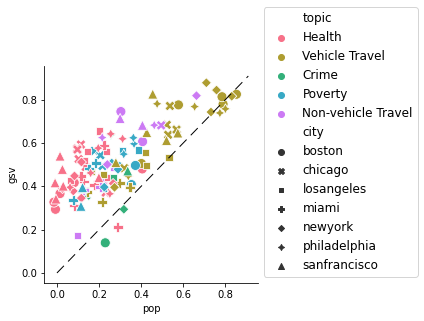

In [83]:
result4 = pd.concat([popresult,
                     poiresult,
                     gsvresult])
result4 = result4[result4["target"].isin(target)]
viz4 = result4.pivot(columns = "variables", values = "testR2", index = ["city","target", "topic"]).reset_index().dropna()
plotscatter("pop",
            "gsv",
            viz4,
            "city",
            "topic", 
            "Fig3_b_SVF_population_comparison", 
            (6,4.3),
            reg = False) # indicating GSV results are very city specific

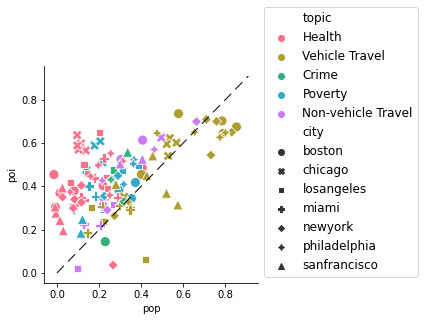

In [84]:
plotscatter("pop",
            "poi",
            viz4[viz4["poi"]>0],
            "city",
            "topic", 
            "Fig3_a_POI_population_comparison", 
            (6,4.3),
            reg = False) # indicating GSV results are very city specific

In [64]:
# calculate the difference of R2
from scipy import stats
stats.ttest_ind(viz4["gsv"], viz4["pop"])
viz4["gsv-pop"] = viz4["gsv"] - viz4["pop"]

viz4["poi-pop"] = viz4["poi"] - viz4["pop"]
viz4[["poi-pop", "gsv-pop"]].describe()

variables,poi-pop,gsv-pop
count,118.000000,118.000000
mean,0.097518,0.228001
std,0.362027,0.137566
min,-2.940606,-0.090388
25%,0.025351,0.126684
50%,0.130446,0.230031
75%,0.245576,0.334636
max,0.540932,0.525524


# Fig. 4

In [32]:
# direct use R2
result6 = pd.concat([result_core_city,
                     poiresult,
                     gsvresult,
                     result_core_gsv_city,
                     result_core_poi_city,
                     poigsvresult,
                     result_core_poi_gsv_city
                    ]).pivot(columns = "variables", 
                             index = ["topic", "city", "target"], 
                             values= "testR2").reset_index()
# result6["topic"] = result6["target"].apply(lambda x:topicdict[x])
result6.head()

variables,topic,city,target,core,core+gsv,core+poi,core+poi+gsv,gsv,poi,poi+gsv
0,Crime,boston,logcrime,0.173024,0.347775,0.300106,0.296400,0.139368,0.144370,0.179055
1,Crime,boston,logpetty,0.080273,0.245770,0.285745,0.293326,0.105527,0.257057,0.276447
2,Crime,chicago,logcrime,0.569414,0.669498,0.648943,0.708993,0.358161,0.475610,0.571775
3,Crime,chicago,logpetty,0.364133,0.565575,0.609713,0.682425,0.157067,0.489065,0.533897
4,Crime,losangeles,logcrime,0.296296,0.511246,0.440477,0.530806,0.439257,0.475647,0.572016


In [42]:
viz = result6[result6["target"].isin(target)].reset_index(drop = True)
viz["meancore+gsv"] = viz.groupby("target")["core+gsv"].transform("mean")
# viz = viz.sort_values("meancore+gsv", ascending = False)
viz["order"] = viz["topic"].apply(lambda x: plotorderdict[x])
viz = viz.dropna().sort_values("order").reset_index(drop = True)

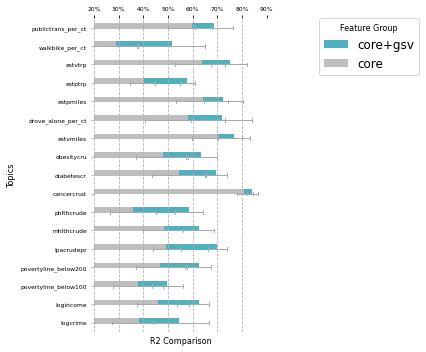

In [45]:
import matplotlib.ticker as mtick
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .3)
def compareR2(x1, x2, viz, twobar = True):
    fig, ax = plt.subplots(figsize=(4,5))
    if twobar:
        g = sns.barplot(x=x1,  y="target", data=viz, orient = 'h', color = colorvaris["gsv"], ax = ax,
                   label = x1, 
                        errcolor = "darkgrey",
                        capsize=0.2,
                        errwidth = 1
                       )
    
    s = sns.barplot(x=x2,  y="target", data=viz, orient = 'h', color = colorvaris[x2], ax = ax,
               label =x2,
                    errcolor = "darkgrey",
                    capsize=0.2,
                   errwidth = 1)

    change_width(ax, .30)

    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #     ax.spines['top'].set_color('grey')
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

    ax.grid(which='major', axis='x', linestyle = '--')

    ax.axvline(x = 0, 
                       color = 'white', 
                       linestyle = '-',
                       linewidth = 4)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    ax.set_xlim(0.2, 0.90)

    ax.tick_params(axis='x', labelsize= 6
                  )
    ax.tick_params(axis='y', labelsize= 6, color = 'darkgrey'
                      )

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_xlabel("R2 Comparison", size = 8)

    ax.set_ylabel("Topics", size = 8)
    plt.tight_layout()
    plt.legend(title="Feature Group",
               bbox_to_anchor=(1.3, 1), 
               loc='upper left', 
               borderaxespad=0, fontsize = 'large', title_fontsize = 8)
    plt.savefig(os.path.join(graphicsave, f"Fig_4_{x1}_{x2}.svg"), transparent = True, dpi = 300)
    
compareR2("core+gsv", "core", viz)

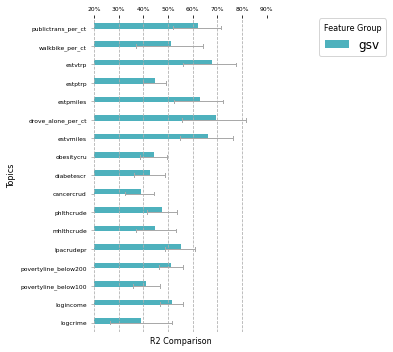

In [46]:
compareR2("core+poi", "gsv", viz, twobar = False)

# Fig. S10


In [24]:
combineddf = pd.concat([gsvresult, poiresult]).reset_index(drop = True)\
.pivot(columns = "variables", values = "testR2", index = ["city","target","topic"]).reset_index().dropna()

from scipy.stats.stats import pearsonr
combineddf = pd.concat([gsvresult, poiresult]).reset_index(drop = True).pivot(columns = "variables", 
                                                                              values = "testR2", 
                                                                              index = ["city","target","topic"]).reset_index().dropna()
test = combineddf[combineddf["poi"]>0] # drop the extreme cases for POI prediction
# test2 = combineddf[~combineddf["target"].isin(["logcrimeper", "logpettyper"])]
pearsonr(test["gsv"], test["poi"])

(0.7349849547839208, 1.159566416429237e-22)

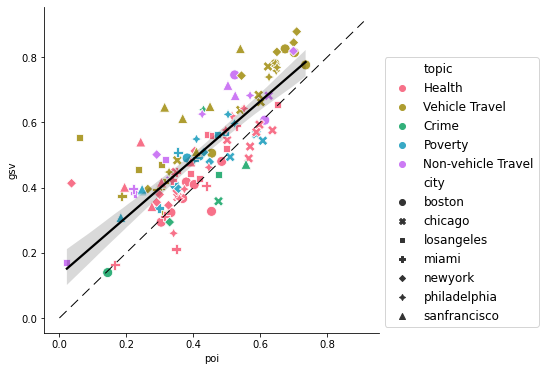

In [27]:
# fig S10
plotscatter( "poi", "gsv",
            test[~test["target"].isin(["logpettyper","logpetty"])],
            "city",
            "topic", 
            "Fig_S10",
            figsize = (6,6),
            reg = True) # indicating GSV results are very city specific

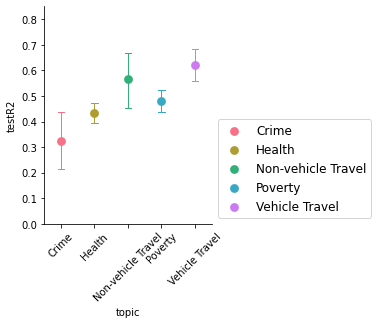

In [20]:
# FIGURE S9
def plotpredict(result_gsv_city, x, hue, filename):
    fig, ax = plt.subplots(figsize = (3,4))
    sns.set_palette("husl",len(result_gsv_city["topic"].unique()))
    sns.pointplot(
        y  = "testR2",
        x = x,
        hue = hue,
        data = result_gsv_city,
        join=False,
         ci=98,
        capsize = 0.2,
        errwidth = 1
    )
    ax.set(ylim=(0, 0.85))
    # ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])

    plt.legend(fontsize='large', title_fontsize='10', loc='lower left', bbox_to_anchor=(1, 0))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    plt.xticks(rotation=45, size=10)
    
    plt.savefig(os.path.join(graphicsave, f"{filename}.svg"))
plotpredict(gsvresult[gsvresult["target"].isin(target)], 
            "topic", 
            "topic", 
            "S9_gsvall_ct")